In [1]:
import torch, torchvision
from tqdm.notebook import tqdm

In [9]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [15]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [16]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 256

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=16)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=16)


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [17]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10),
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [25]:
model = Classifier(16, 4, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [256, 10]                 --
├─Conv2d: 1-1                            [256, 16, 32, 32]         64
├─LayerNorm: 1-2                         [256, 16, 32, 32]         32,768
├─Sequential: 1-3                        [256, 128, 4, 4]          --
│    └─ConvNextBlock: 2-1                [256, 16, 32, 32]         --
│    │    └─Conv2d: 3-1                  [256, 16, 32, 32]         800
│    │    └─LayerNorm: 3-2               [256, 16, 32, 32]         32,768
│    │    └─Conv2d: 3-3                  [256, 64, 32, 32]         1,088
│    │    └─Conv2d: 3-4                  [256, 16, 32, 32]         1,040
│    └─ConvNextBlock: 2-2                [256, 16, 32, 32]         --
│    │    └─Conv2d: 3-5                  [256, 16, 32, 32]         800
│    │    └─LayerNorm: 3-6               [256, 16, 32, 32]         32,768
│    │    └─Conv2d: 3-7                  [256, 64, 32, 32]       

In [26]:
%%time

train_acc = []
train_loss = []
val_acc = []
val_loss = []
epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        train_acc.append(acc); train_loss.append(loss)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        val_acc.append(acc_val); val_loss.append(loss_val)
        
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    

Train Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0: training loss: 1.488, accuracy: 46.387


Validate Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.485, accuracy: 45.947


Train Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: training loss: 1.291, accuracy: 53.628


Validate Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.311, accuracy: 51.357


Train Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: training loss: 1.143, accuracy: 58.952


Validate Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.189, accuracy: 55.986


Train Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: training loss: 1.048, accuracy: 62.721


Validate Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.102, accuracy: 59.385


Train Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: training loss: 0.925, accuracy: 67.334


Validate Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.025, accuracy: 62.900


Train Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: training loss: 0.836, accuracy: 70.745


Validate Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.944, accuracy: 65.234


Train Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: training loss: 0.778, accuracy: 72.445


Validate Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.921, accuracy: 66.934


Train Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: training loss: 0.716, accuracy: 74.923


Validate Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.872, accuracy: 68.564


Train Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: training loss: 0.662, accuracy: 76.485


Validate Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.835, accuracy: 69.219


Train Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9: training loss: 0.590, accuracy: 79.302


Validate Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.796, accuracy: 71.318


Train Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: training loss: 0.560, accuracy: 80.086


Validate Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.809, accuracy: 71.035


Train Epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11: training loss: 0.530, accuracy: 81.285


Validate Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.807, accuracy: 71.621


Train Epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12: training loss: 0.478, accuracy: 83.094


Validate Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.767, accuracy: 72.998


Train Epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13: training loss: 0.436, accuracy: 84.594


Validate Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.756, accuracy: 73.008


Train Epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14: training loss: 0.401, accuracy: 85.803


Validate Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.755, accuracy: 73.047


Train Epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15: training loss: 0.415, accuracy: 85.104


Validate Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.798, accuracy: 73.086


Train Epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16: training loss: 0.376, accuracy: 86.744


Validate Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.801, accuracy: 72.988


Train Epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17: training loss: 0.352, accuracy: 87.440


Validate Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.818, accuracy: 73.145


Train Epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18: training loss: 0.309, accuracy: 88.953


Validate Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.792, accuracy: 74.229


Train Epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19: training loss: 0.304, accuracy: 89.110


Validate Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.776, accuracy: 73.633


Train Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20: training loss: 0.292, accuracy: 89.478


Validate Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.822, accuracy: 73.447


Train Epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21: training loss: 0.286, accuracy: 89.416


Validate Epoch 21:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.832, accuracy: 73.525


Train Epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22: training loss: 0.251, accuracy: 91.123


Validate Epoch 22:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.827, accuracy: 74.170


Train Epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23: training loss: 0.251, accuracy: 90.742


Validate Epoch 23:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.828, accuracy: 74.404


Train Epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24: training loss: 0.214, accuracy: 92.222


Validate Epoch 24:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.822, accuracy: 74.658


Train Epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25: training loss: 0.202, accuracy: 92.673


Validate Epoch 25:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.827, accuracy: 74.658


Train Epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26: training loss: 0.212, accuracy: 92.123


Validate Epoch 26:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.871, accuracy: 74.590


Train Epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27: training loss: 0.187, accuracy: 93.158


Validate Epoch 27:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.833, accuracy: 75.352


Train Epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28: training loss: 0.192, accuracy: 92.867


Validate Epoch 28:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.871, accuracy: 74.629


Train Epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29: training loss: 0.198, accuracy: 92.795


Validate Epoch 29:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.895, accuracy: 73.965
CPU times: user 12min 37s, sys: 1min 29s, total: 14min 6s
Wall time: 2min 32s


# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [21]:
import matplotlib.pyplot as plt

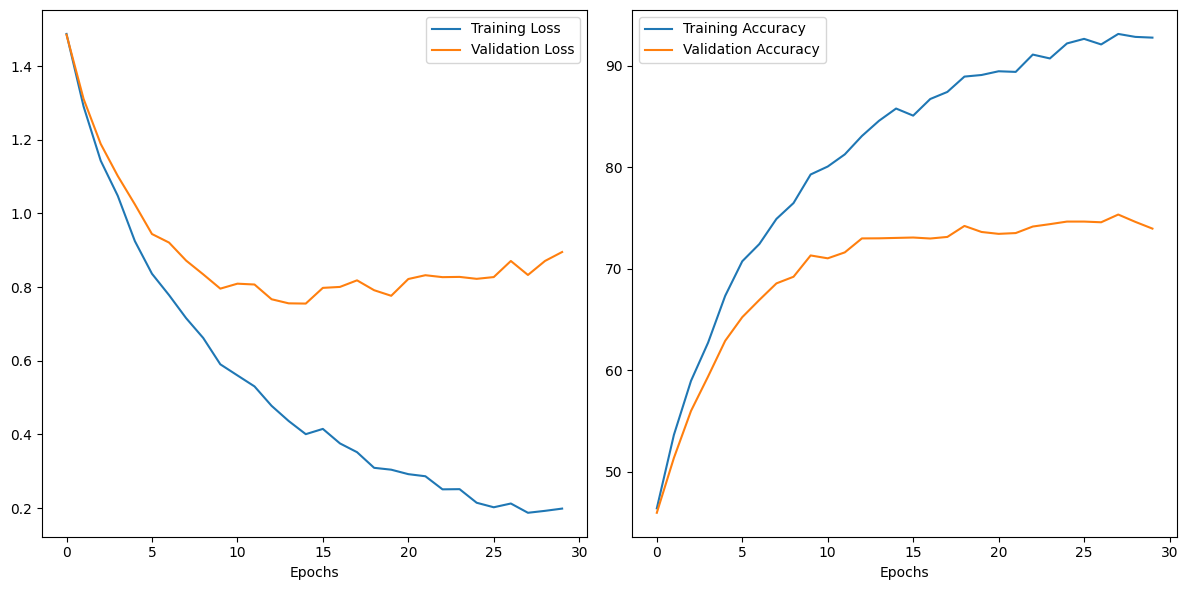

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

I tried several things that didn't improve performance. I tried adding a large (1024x1024) hidden layer in the output FFNN, but apparently the smaller dense layer is just as good. I also tried changing GeLU to ReLU but saw no real difference. I also tried using a smaller network with "model = Classifier(8, 2, 1)" and as expected this did much worse, but the training loss was closer to the validation loss. Finally I tried just cranking up the size of the network to "model = Classifier(64, 4, 4)". This increased the number of filters in each layer and also doubled the number of convolution/dropout layers. I thought this would improve performance because it has many more parameters. I found this didn't do any better than just using "model = Classifier(16, 4, 2)". We seem to be at the limit of the dataset with convolutional neural networks. 

The plots above show how the performance of the model using `model = Classifier(16,4,2)` and the `AdamW` optimizer.